In [19]:
import pandas as pd
import numpy as np
from tabata.opset import Opset
from dtaidistance import dtw
import matplotlib.pyplot as plt

In [20]:
input_file = "../Data/normalized/AFL1EB_normalized.h5"
ds = Opset(input_file)

print(f"Nombre total d'enregistrements : {len(ds)}")


Nombre total d'enregistrements : 47


In [21]:
# Sélection d'un vol de référence basé sur la durée médiane

durations = []
for df in ds:
    durations.append((df.index[-1] - df.index[0]).total_seconds())
median_index = np.argsort(durations)[len(durations)//2]
reference_id = ds.records[median_index]

print(f"Vol de référence choisi : {reference_id}")
df_reference = ds[reference_id]

Vol de référence choisi : /record_16


In [22]:
from dtaidistance import dtw

def synchronize_with_dtw(ds, reference_id, target_id, col="ALT[m]"):
    reference_pos = ds.records.index(reference_id)
    target_pos = ds.records.index(target_id)

    df_reference = ds[reference_pos]
    df_target = ds[target_pos]

    ref_sequence = df_reference["ALT[m]"].values
    target_sequence = df_target["ALT[m]"].values

    distance, paths = dtw.warping_paths(ref_sequence, target_sequence)
    
    print(f"Distance DTW entre {reference_id} et {target_id} : {distance}")
    ds.plot(pos=reference_pos, name="ALT[m]")
    ds.plot(pos=target_pos, name="ALT[m]")     
    
    return distance, paths, df_reference, df_target

target_id = "/record_01"
distance, paths, df_reference, df_target = synchronize_with_dtw(ds, reference_id, target_id)
best_path = dtw.best_path(paths)

Distance DTW entre /record_16 et /record_01 : 0.1598114664853114


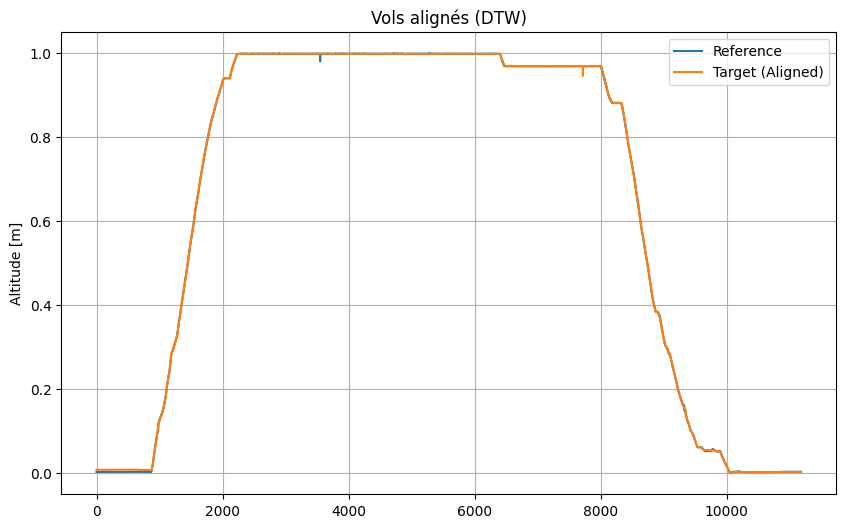

In [23]:
def align_flights(reference, target, best_path, col="ALT[m]"):
    aligned_ref = []
    aligned_target = []
    
    for i, j in best_path:
        aligned_ref.append(reference[col].iloc[i])
        aligned_target.append(target[col].iloc[j])
    
    return pd.DataFrame({
        "Reference": aligned_ref,
        "Target (Aligned)": aligned_target
    })

aligned_df = align_flights(df_reference, df_target, best_path)

aligned_df.plot(figsize=(10, 6), title="Vols alignés (DTW)")

plt.ylabel("Altitude [m]")
plt.grid()
plt.show()


In [24]:
from math import *
from sklearn.metrics import mean_squared_error
correlation = aligned_df["Reference"].corr(aligned_df["Target (Aligned)"])
print(f"Corrélation entre les vols après alignement : {correlation}")

mse = mean_squared_error(aligned_df["Reference"], aligned_df["Target (Aligned)"])
print(f"RMSE : {sqrt(mse)}")

print("Taux de compression/dilatation : ",len(aligned_df)/len(df_target))

Corrélation entre les vols après alignement : 0.9999947626912512
RMSE : 0.0015115617170639922
Taux de compression/dilatation :  1.4985923045984717


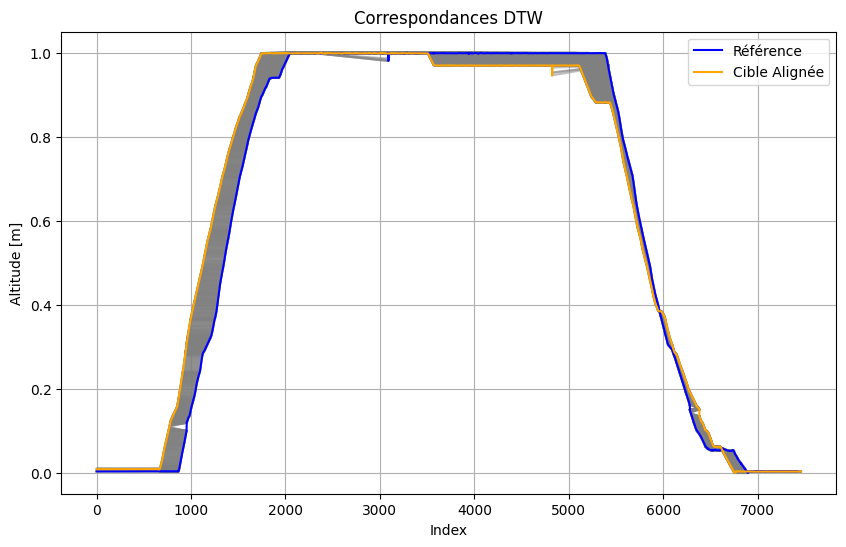

In [25]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
for i, j in best_path:
    plt.plot([i, j], [df_reference["ALT[m]"].iloc[i], df_target["ALT[m]"].iloc[j]], color="gray", alpha=0.5)

plt.plot(df_reference["ALT[m]"].values, label="Référence", color="blue")
plt.plot(df_target["ALT[m]"].values, label="Cible Alignée", color="orange")
plt.xlabel("Index")
plt.ylabel("Altitude [m]")
plt.title("Correspondances DTW")
plt.legend()
plt.grid()
plt.show()

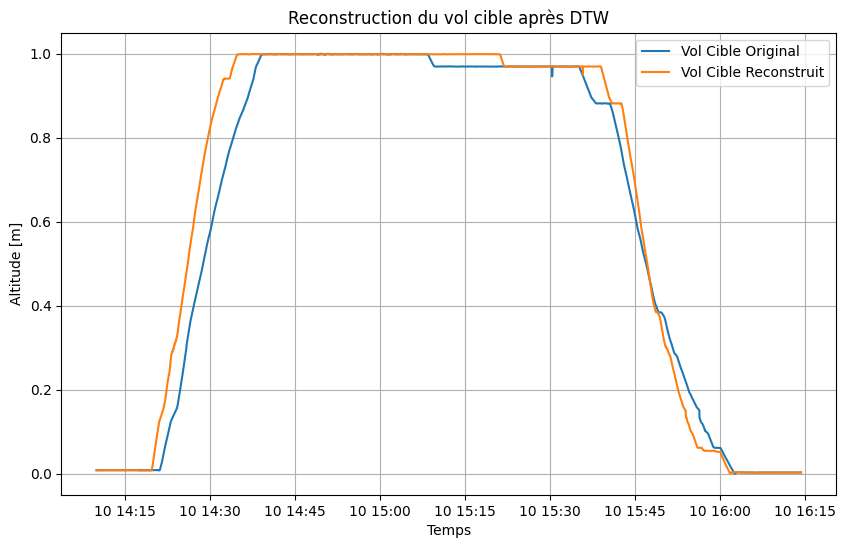

In [26]:
from scipy.interpolate import interp1d

def reconstruct_target(target, best_path):

    target_values = []
    for _, j in best_path:
        target_values.append(target["ALT[m]"].iloc[j])
    
    interp_func = interp1d(range(len(target_values)), target_values, kind='linear', fill_value="extrapolate")
    reconstructed_target = interp_func(np.linspace(0, len(target_values)-1, len(target["ALT[m]"])))
    
    reconstructed_df = pd.DataFrame({
        "ALT[m]": reconstructed_target
    }, index=target.index)
    
    return reconstructed_df

reconstructed_target_df = reconstruct_target(df_target, best_path)

plt.figure(figsize=(10, 6))
plt.plot(df_target.index, df_target["ALT[m]"], label="Vol Cible Original")
plt.plot(reconstructed_target_df.index, reconstructed_target_df["ALT[m]"], label="Vol Cible Reconstruit")
plt.xlabel("Temps")
plt.ylabel("Altitude [m]")
plt.title("Reconstruction du vol cible après DTW")
plt.legend()
plt.grid()
plt.show()

In [27]:
mse_reconstruction = mean_squared_error(df_target["ALT[m]"], reconstructed_target_df["ALT[m]"])
print(f"RMSE : {sqrt(mse_reconstruction)}")
correlation = df_target["ALT[m]"].corr(reconstructed_target_df["ALT[m]"])
print(f"Corrélation entre l'original et la reconstruction : {correlation}")

RMSE : 0.07400489227042058
Corrélation entre l'original et la reconstruction : 0.9868618759755267
